In [ ]:
# finding single and double-positive cells

In [2]:
library(Seurat)
library(dplyr)
library(ggplot2)
library(ggpointdensity)
library(cowplot)
library(viridis)
library(ggbeeswarm)

In [3]:
# dataset 2
sc1 = readRDS('Zeisel_data.rds')
sc1
mtd1 = sc1@meta.data
mtd1[1:2,]

An object of class Seurat 
27998 features across 160796 samples within 1 assay 
Active assay: RNA (27998 features, 0 variable features)
 2 layers present: counts, data

orig.ident nCount_RNA nFeature_RNA Age     
10X82_2_TCTCTCACCAGTTA- 10X82      19065      4966         p21, p23
10X82_2_TATTATCTACCAGA- 10X82      21617      5170         p21, p23
                        AnalysisPool AnalysisProject
10X82_2_TCTCTCACCAGTTA- Enteric      Adolescent     
10X82_2_TATTATCTACCAGA- Enteric      Adolescent     
                        Bucket                                            
10X82_2_TCTCTCACCAGTTA- /Users/sten/build_20171205/L4_Enteric_Neurons.loom
10X82_2_TATTATCTACCAGA- /Users/sten/build_20171205/L4_Enteric_Neurons.loom
                        CellConc Cell_Conc ChipID ⋯ _Total _Valid _X      
10X82_2_TCTCTCACCAGTTA- 1000     1000      10X82  ⋯ 19065  1      32.19325
10X82_2_TATTATCTACCAGA- 1000     1000      10X82  ⋯ 21617  1      32.22355
                        _Y       _tSNE1    _tSNE2  
10X82_2_TCTCTCACCAGTTA- 57.79691 -25.77720 33.12547
10X82_2_TATTATCTACCAGA- 57.31415 -25.66751 33.25327
                        cDNAConcNanogramPerMicroliter cDNALibOk cDNA_Lib_Ok
10X82_2_TCTCTCACCAGTTA- 7.4                           Y         Y          
10X82_2_TATTATCTACCAGA- 7.4                           Y         Y          
                        ngperul_cDNA
10X82_2_TCTCTCACCAGTTA- 7,4         
10X82_2_TATTATCTACCAGA- 7,4

In [4]:
table(mtd1$Age)


       ?       6w p12, p35 p16, p24      p19 p19, p21      p20      p21 
      30      893     2340     2517    13036     8795    20235     9124 
  p21-23 p21, p23      p22   p22-24      p23      p24      p25   p25-27 
   10322     2845    12649       89    11400     6020     9857    10965 
     p26      p27      p28      p29      p30      p60 
   12185     1304     4559    16148      655     4828 

In [5]:
table(mtd1$Subclass)


             Astrocyte          Bergmann-glia           Enteric-glia 
                 19674                    839                  10327 
  Enteric-glia,Cycling              Ependymal                 Immune 
                   161                   1370                   7454 
               Neurons        Neurons,Cycling                    OEC 
                 73704                    835                   1978 
                Oligos         Oligos,Cycling         Satellite-glia 
                 30932                    141                    651 
Satellite-glia,Cycling                Schwann                    Ttr 
                    31                     47                    456 
              Vascular 
                 12196 

In [6]:
# cpm-normalize the raw counts
seu = CreateSeuratObject(counts = sc1@assays$RNA@counts, meta.data = sc1@meta.data)
seu <- NormalizeData(seu, normalization.method = "RC", scale.factor = 1e6)
exp1 = LayerData(seu, assay = 'RNA', layer = 'data') # cpm

Normalizing layer: counts



In [7]:
sum(exp1['Neurog2',]>0)
sum(exp1['Ascl1',]>0)
sum(exp1['Neurog1',]>0)

[1] 555

[1] 2855

[1] 45

In [8]:
# get new cell types for A1N2 and N1N2 cases
get_celltype_new <- function(exp0, g1, g2){
    gene1_exp = exp0[g1,]
    gene2_exp = exp0[g2,]
    
    vec1 = rank(gene1_exp)
    vec2 = rank(gene2_exp)
    
    vec1 <- vec1/max(vec1, na.rm = T)
    vec2 <- vec2/max(vec2, na.rm = T)

    id1 = which(vec1>0.7 & vec2>0.7) # dbl-positive
    id2 = which(vec1>0.7 & vec2<=0.7) # neurog2
    id3 = which(vec1<=0.7 & vec2>0.7) # ascl1

    ctypes = rep('none', dim(exp0)[2])
    ctypes[id1] = 'double_positive'
    ctypes[id2] = paste0(g1, '_positive')
    ctypes[id3] = paste0(g2, '_positive')

    return(ctypes)
}

In [9]:
# get cell type labels based on ranked exp bins
seu$celltype_A1N2 = get_celltype_new(exp1, 'Neurog2', 'Ascl1')
seu$celltype_N1N2 = get_celltype_new(exp1, 'Neurog2', 'Neurog1')

In [10]:
# save file
saveids = which(exp1['Neurog2',]>0 | exp1['Ascl1',]>0 | exp1['Neurog1',]>0)
length(saveids)

sce = CreateSeuratObject(counts = LayerData(seu, assay = 'RNA', layer = 'counts')[,saveids], 
                         data = exp1[,saveids], meta.data = seu@meta.data[saveids,])
sce

# save
saveRDS(sce, file = 'Zeisel_A1N1N2.rds')

[1] 3395

An object of class Seurat 
27998 features across 3395 samples within 1 assay 
Active assay: RNA (27998 features, 0 variable features)
 2 layers present: counts, data

In [16]:
gene1_exp = exp1['Neurog2',]
gene2_exp = exp1['Ascl1',]

vec1 = rank(gene1_exp)
vec2 = rank(gene2_exp)

vec1 <- vec1/max(vec1, na.rm = T)
vec2 <- vec2/max(vec2, na.rm = T)

In [17]:
cor(vec1, vec2, method = 'spearman')

[1] 0.03618546

In [18]:
dat = data.frame(m1_exp = log2(1+gene1_exp), m2_exp = log2(1+gene2_exp),
                 m1_rank = vec1, m2_rank = vec2)
dat[1:2,]

m1_exp m2_exp m1_rank   m2_rank  
10X82_2_TCTCTCACCAGTTA- 0      0      0.4982773 0.4911254
10X82_2_TATTATCTACCAGA- 0      0      0.4982773 0.4911254

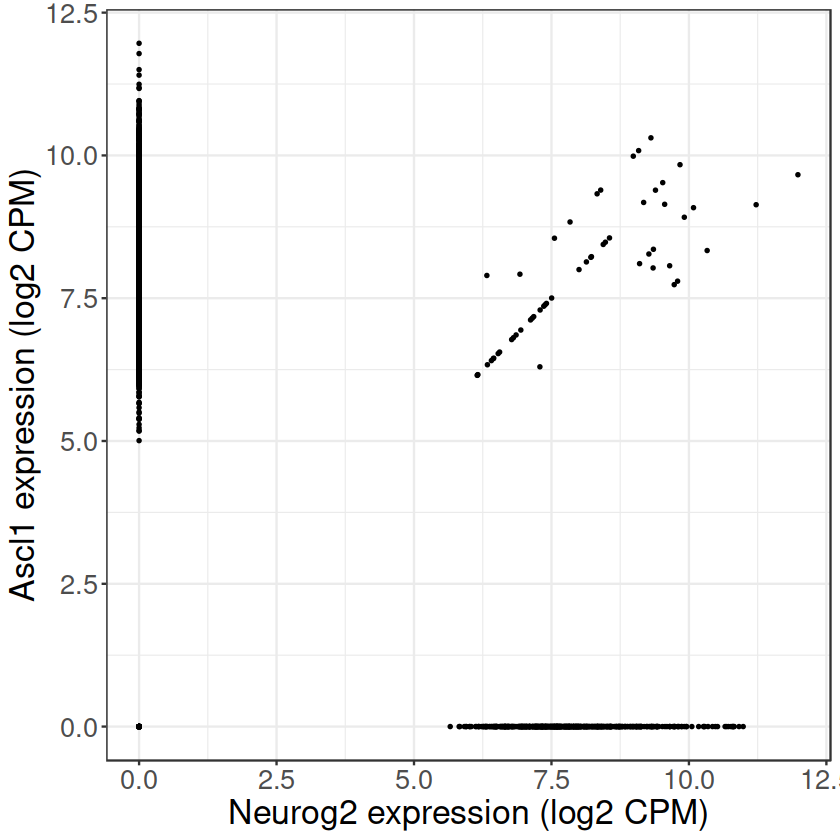

In [19]:
# png('aa-gene-exp-coexp.png', width = 5, height = 5, res = 300, units = 'in')
ggplot(dat, aes(x = m1_exp, y = m2_exp)) +
geom_point(size = 0.5) + theme_bw() + theme(text = element_text(size = 20)) +
xlab('Neurog2 expression (log2 CPM)') + ylab('Ascl1 expression (log2 CPM)')
# dev.off()

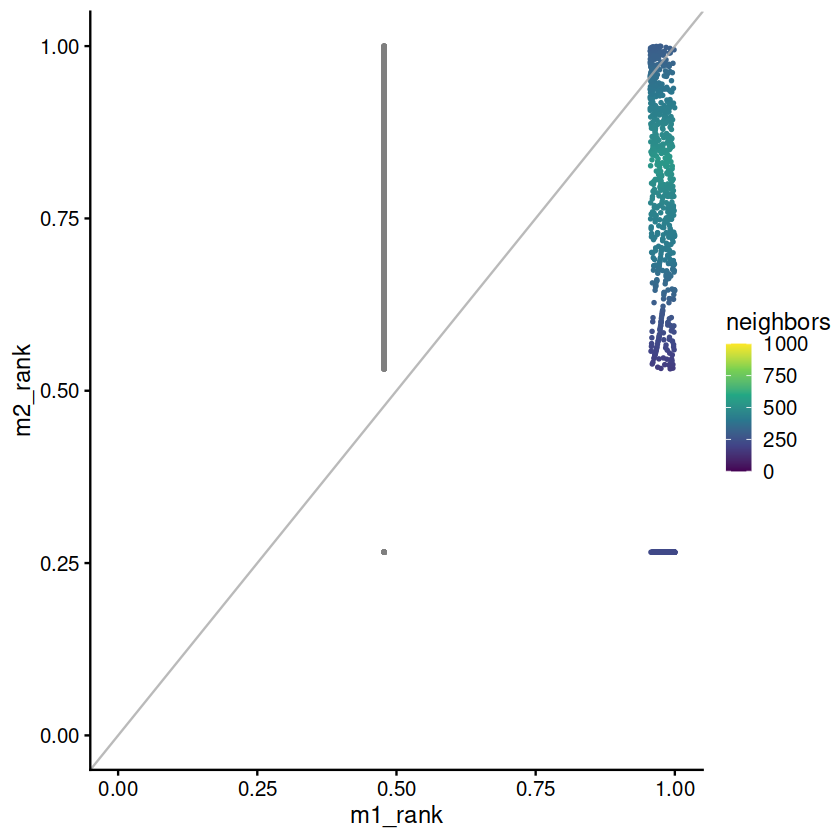

In [93]:
# png(paste0('aa-', g1, '-density-coexp.png'), width = 10, height = 5, res = 300, units = 'in')
# pdf(paste0('aa-hc-', g3, '-density-coexp.pdf'), width = 5, height = 5)

ggplot(dat, aes(x = m1_rank, y = m2_rank)) +
geom_pointdensity(size = 0.5) + scale_color_viridis_c(limits = c(0,1000)) + 
geom_abline(intercept = 0, slope = 1,col = 'darkgray', lwd = 0.5, alpha = 0.8)+
theme_cowplot() + labs(col = 'neighbors') + xlim(0,1) + ylim(0,1)

# dev.off()

In [20]:
id1 = which(vec1>0.7 & vec2>0.7) # dbl-positive
id2 = which(vec1>0.7 & vec2<0.7) # neurog2
id3 = which(vec1<0.7 & vec2>0.7) # ascl1

length(id1)
length(id2)
length(id3)

[1] 55

[1] 500

[1] 2800

In [21]:
# cluster 8,10,16,22 for dbl-pos; cluster 32 for neurog2+
table(as.character(mtd1$Subclass[id1]))


      Astrocyte         Neurons Neurons,Cycling             OEC 
              3              28              23               1 

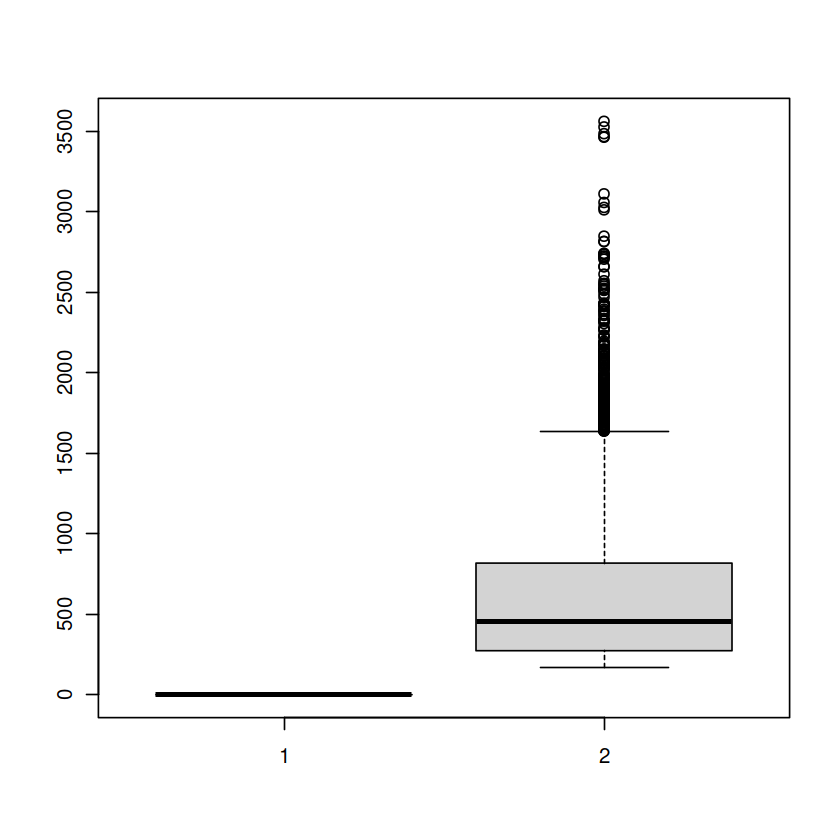

In [96]:
boxplot(exp1['Neurog2', id3], exp1['Ascl1', id3])

In [22]:
# Alex's target genes
alex = c('Bcl11a', 'Bcl11b', 'Nhlh1', 'Nhlh2', 'Sox2', 'Sox9', 'Gfap',
        'Pax6', 'Prom1', 'Foxj1', 'Rbfox3', 'Nes', 'Hopx', 'Dcx',
        'Bdnf', 'Pdgfra', 'S100b')
length(alex)

[1] 17

[1] "Pax6"

[1] 6406

[1] 9

[1] 29

[1] 160

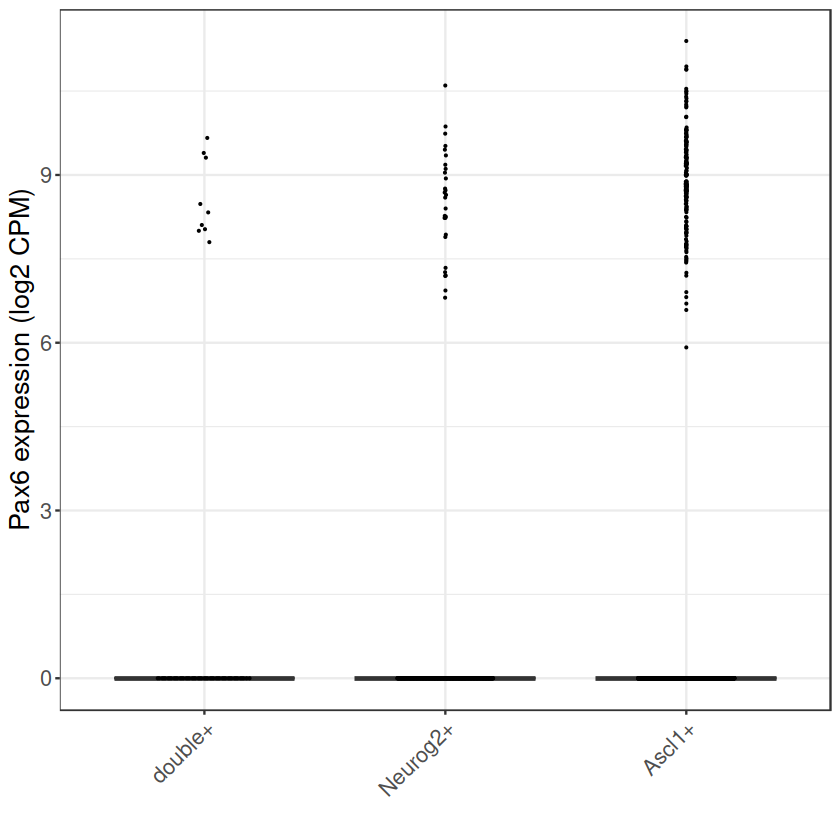

In [23]:
# other coexpressing genes
currgene = 'Pax6'
currgene
sum(exp1[currgene,]>0)

# no. of cells with >0 exp in each case
sum(exp1[currgene, id1]>0)
sum(exp1[currgene, id2]>0)
sum(exp1[currgene, id3]>0)

exp_vec = exp1[currgene,]
vec3 = rank(exp_vec)
vec3 <- vec3/max(vec3, na.rm = T)
plotdf = data.frame(gene = currgene, 
                    ctype = c(rep('double+', length(id1)), rep('Neurog2+', length(id2)), rep('Ascl1+', length(id3))),
                    exp = c(log2(1+exp_vec[id1]), log2(1+exp_vec[id2]), log2(1+exp_vec[id3])),
                    rank_exp = c(vec3[id1], vec3[id2], vec3[id3]))
plotdf$ctype = factor(plotdf$ctype, levels = c('double+', 'Neurog2+', 'Ascl1+'))

# png(paste0('aa-', currgene, '-exp.png'), width = 3.5, height = 5, res = 300, units = 'in')
ggplot(plotdf, aes(x = ctype, y = exp, fill = ctype)) + 
geom_boxplot(outlier.shape = NA) + geom_quasirandom(size = 0.1, width = 0.2) + theme_bw() +
theme(text = element_text(size = 16), axis.text.x = element_text(angle = 45, hjust = 1), legend.position = 'none') +
xlab('') + ylab(paste0(currgene, ' expression (log2 CPM)')) + scale_fill_manual(values = c('#ff6b6b', '#48bf91', '#ffb403'))
# dev.off()

In [24]:
# which genes show the pattern we want? (apart from Alex's targets)
# expr in double-positive > single-positive cells
options(warn = -1)
allgenes = setdiff(rownames(exp1), c('Neurog2', 'Ascl1'))
length(allgenes)

# get row ranks
r1 = matrixStats::rowRanks(as.matrix(exp1[allgenes,c(id1,id2,id3)]))
r1 <- r1/dim(exp1)[2]

pb = txtProgressBar(min = 0, max = length(allgenes), initial = 0)
gset = c()

for(ii in 1:length(allgenes)){
    vec3 = r1[ii,]

    m1 = mean(vec3[1:length(id1)])
    m2 = mean(vec3[(length(id1)+1):(length(id1)+length(id2))])
    m3 = mean(vec3[(length(id1)+length(id2)+1):(length(id1)+length(id2)+length(id3))])
    
    if(m1>m2 & m1>m3){
        gset = c(gset, allgenes[ii])
    }
    setTxtProgressBar(pb, ii)
}

length(gset)

[1] 27996

[1] 5006

In [25]:
# wow, 10% follow our trend
pb = txtProgressBar(min = 0, max = length(gset), initial = 0)

dfnew = data.frame(gene = gset, dbl_exp = 0, gene1_exp = 0, 
                   gene2_exp = 0, retain = 0)

r2 = log2(1+exp1[gset,])

for(ii in 1:length(gset)){
    vec3 = r2[ii,]

    m1 = mean(vec3[id1])
    m2 = mean(vec3[id2])
    m3 = mean(vec3[id3])    

    dfnew$dbl_exp[ii] = m1
    dfnew$gene1_exp[ii] = m2
    dfnew$gene2_exp[ii] = m3
    
    if(m1>1.5*m2 & m1>1.5*m3 & m1>2){
        dfnew$retain[ii] = 1
    }
    setTxtProgressBar(pb, ii)
}
dfnew <- dfnew %>% arrange(-retain, -dbl_exp)

sum(dfnew$retain)
dfnew[1:2,]

[1] 295

gene          dbl_exp  gene1_exp gene2_exp retain
1 2700094K13Rik 7.752606 4.536993  5.091135  1     
2 Psmb2         7.650784 4.983498  4.251526  1

In [26]:
dfnew$gene[dfnew$retain==1]

[1] "2700094K13Rik" "Psmb2"         "Mrpl28"        "Snrpd1"       
  [5] "Tubb4b"        "Uba52"         "Cacybp"        "Hmgb3"        
  [9] "Dctpp1"        "Cdk4"          "Snrpb"         "Prmt1"        
 [13] "Dpy30"         "Ahsa1"         "Psma6"         "Polr2c"       
 [17] "Thrsp"         "Dtymk"         "Smim11"        "2700029M09Rik"
 [21] "Llph"          "G3bp1"         "Hnrnpf"        "Snrpa1"       
 [25] "Dph3"          "Dek"           "Dut"           "Psmc2"        
 [29] "Ier5"          "Snrpb2"        "Fabp7"         "Hmgb2"        
 [33] "Eif6"          "Anp32e"        "Mdk"           "H2afx"        
 [37] "Cct4"          "Cops4"         "Rsl1d1"        "Cct3"         
 [41] "Cnpy2"         "Eef1d"         "Anp32b"        "Etfb"         
 [45] "Rnaseh2c"      "Lsm2"          "Paics"         "Nudt21"       
 [49] "Hes6"          "Txnl1"         "1810022K09Rik" "Atp6v0e"      
 [53] "Rbmxl1"        "Hdac2"         "Ddx1"          "Apoa1bp"      
 [57] "Cdc26"         "Eif2s1"        "Fam96a"        "Itpa"         
 [61] "Emx1"          "Tmem208"       "Hmgn2"         "Gstp1"        
 [65] "Apex1"         "Cks1b"         "Commd1"        "Gadd45g"      
 [69] "Adh5"          "Nsmce4a"       "2810417H13Rik" "Nudcd2"       
 [73] "Pa2g4"         "Cmc2"          "Upf3b"         "Ube2a"        
 [77] "Tmpo"          "Usp14"         "Exosc4"        "Psme2"        
 [81] "Ddost"         "Larp7"         "Myl12a"        "Mrpl49"       
 [85] "Mrpl2"         "Rasl11b"       "1110004E09Rik" "Gng5"         
 [89] "Vps36"         "Ufsp2"         "Eif3b"         "Gpd1"         
 [93] "Cenpm"         "Pcna"          "Cenpw"         "Slc1a3"       
 [97] "Rfc2"          "Dnajc9"        "Psmd10"        "Luc7l"        
[101] "Prdx4"         "Siva1"         "Arfrp1"        "Srsf9"        
[105] "0610010K14Rik" "Psmd9"         "Dnajb1"        "Pigx"         
[109] "Hnrnph3"       "Lockd"         "Ntmt1"         "Kdelr1"       
[113] "Ier2"          "Bckdk"         "Fuca1"         "Birc5"        
[117] "Ift27"         "Stoml1"        "Vps37b"        "Aggf1"        
[121] "Med22"         "E130114P18Rik" "Pttg1"         "Cgrrf1"       
[125] "Ciapin1"       "Rcc2"          "Zfp422"        "Ap3s2"        
[129] "Fezf2"         "Tipin"         "Hax1"          "Gsta4"        
[133] "Cdca8"         "Dap3"          "Rnmt"          "Clic1"        
[137] "Sf3b4"         "Lyar"          "Krt12"         "Ncaph2"       
[141] "Cdc5l"         "Snx6"          "Asf1a"         "Seh1l"        
[145] "Ube2c"         "Pole3"         "Gtf3c6"        "Taf12"        
[149] "Eif4a3"        "Utp11l"        "Ubald2"        "Exosc8"       
[153] "Sel1l3"        "Alad"          "Timm50"        "Nsmce1"       
[157] "Cdk5rap3"      "Phf23"         "Etfa"          "Dnajc24"      
[161] "B9d2"          "Fbxo22"        "Nelfe"         "Abcb9"        
[165] "Kat6b"         "Malsu1"        "Faap20"        "Hopx"         
[169] "Pkib"          "Rrm2"          "Tubg1"         "Mrpl39"       
[173] "Tor2a"         "Zfp326"        "Eif3l"         "Pgk1"         
[177] "Blvra"         "Idh2"          "Gtf2b"         "Rpain"        
[181] "Cmc1"          "2310022B05Rik" "Car4"          "Cenpf"        
[185] "Hspa14"        "Chtf8"         "Magoh"         "Mrps30"       
[189] "Fars2"         "Cks2"          "Rpa2"          "Plgrkt"       
[193] "Rpp25l"        "Spg21"         "Ppie"          "Endog"        
[197] "Ctcf"          "Wdr12"         "Pbk"           "Cdca3"        
[201] "Anapc15"       "Rgs20"         "Prmt7"         "Ift43"        
[205] "Akt3"          "Npm3"          "Psmg2"         "Oard1"        
[209] "Sfrp1"         "Smc4"          "Mfge8"         "B9d1"         
[213] "Zpr1"          "Lmnb1"         "Tspan6"        "Dkc1"         
[217] "Ezh2"          "Prc1"          "Dcps"          "Rpa1"         
[221] "Nsmce2"        "Hnrnpa1"       "Zfp24"         "Cenpb"        
[225] "Rhno1"         "Hirip3"        "Pusl1"         "Arl6ip6"      
[229] "Myef2

In [27]:
# df for saving
write.table(dfnew, file = 'zeisel_neurog2_ascl1_geneset.csv', sep = ',',
           row.names = F, col.names = T, quote = F)

In [42]:
# show avg exp and pct expressed
geneset = rev(c('Nes', 'Thrsp', 'Gpc5', 'Efhd2', 'Gpc4', 'Gli2', 'Adarb1'))
plotdf2 = c()

for(ii in 1:length(geneset)){
    currgene = geneset[ii]
    exp_vec = exp1[currgene,]
    
    temp = data.frame(gene = currgene, 
                        ctype = c('double+', 'Neurog2+', 'Ascl1+'),
                        log2_exp = c(mean(log2(1+exp_vec[id1])), mean(log2(1+exp_vec[id2])), mean(log2(1+exp_vec[id3]))),
                        pct_exp = c(sum(exp1[currgene, id1]>0)/length(id1), 
                                sum(exp1[currgene, id2]>0)/length(id2), sum(exp1[currgene, id3]>0)/length(id3)))
    plotdf2 = rbind(plotdf2, temp) 
}

plotdf2$ctype = factor(plotdf2$ctype, levels = c('double+', 'Neurog2+', 'Ascl1+'))
plotdf2$gene = factor(plotdf2$gene, levels = geneset)
plotdf2[1:3,]

gene   ctype    log2_exp  pct_exp  
1 Adarb1 double+  0.6800809 0.1255230
2 Adarb1 Neurog2+ 0.6340548 0.1023018
3 Adarb1 Ascl1+   0.7318099 0.1314126

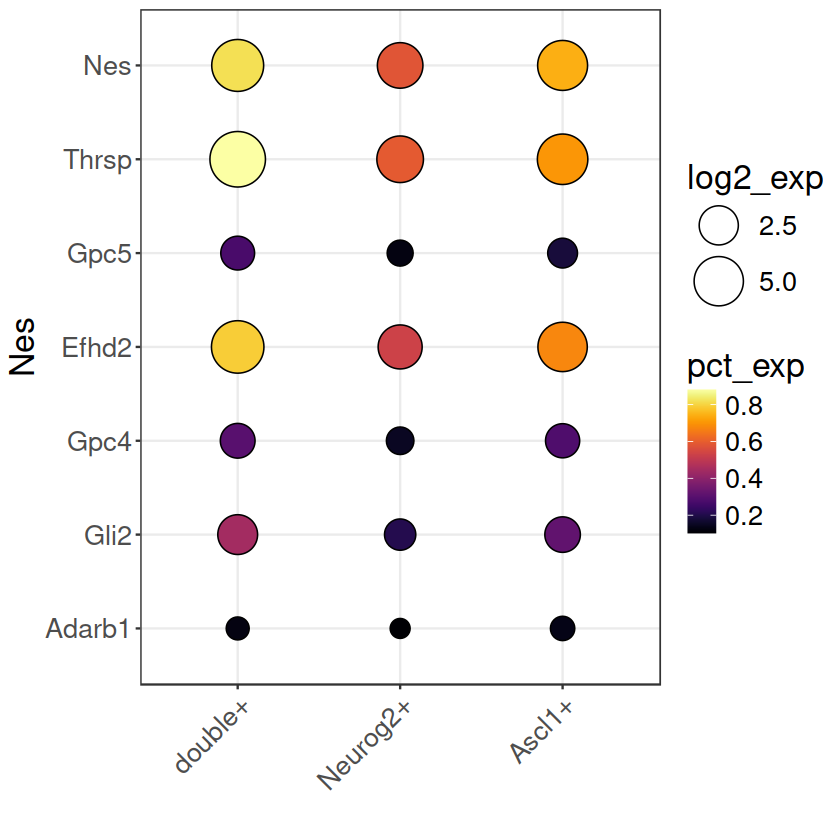

In [45]:
# png('aa-geneset-exp-pct.png', width = 5, height = 6, res = 300, units = 'in')
ggplot(plotdf2, aes(x = ctype, y = gene, label = round(pct_exp*100)/100)) +  
geom_point(shape = 21, color = 'black', aes(fill = pct_exp, size = log2_exp)) + theme_bw() + 
# geom_text(size = 6, hjust = -0.25, vjust = -2) + 
theme(text = element_text(size = 20), axis.text.x = element_text(angle = 45, hjust = 1)) +
xlab('') + ylab(currgene) + scale_fill_viridis(option = 'B') +
scale_size_continuous(breaks = c(0, 2.5, 5, 7.5, 10, 12.5, 15), range = c(5, 15)) 
# dev.off()